# <span style='color:red'>Project 1</span>

#### In this project we use dynamic programming to create a trading schedule that maximizes total number of shares traded, under a model of liquidity impact with memory

In [20]:
import csv
import sys
import scipy.io
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
import time
import matplotlib.pyplot as plt

# #### Suppose we have a total of N shares that we would like to trade over T time periods.  To do so, we produce a schedule
$$ (n_0, n_1, \ldots, n_{T-1}) \quad \text{where each} \quad n_i \ge 0$$
#### Each $n_i$ represents the quantity that we will attempt  to trade at time $i = 0, 1, 2, \ldots, T-1$.  In reality the market will only allow us to trade a smaller quantity at each time period.  We impose the conditions:
$$ \sum_{i=0}^{T-1} n_i \ \le N \quad \text{and} \quad n_{T-1} = N - \text{quantity traded so far}$$
#### This plays out as follows.  Assume that $\alpha > 0$ (and very small) and $0 < \pi < 1$ are given parameters.  Then we run the following process:
#### 1. Initialize $M = 0$.  Then for $i = 0, 1, 2, \ldots, T-1$ we do the following:
#### 2. Compute $M \leftarrow \lceil 0.1*M + 0.9*n_i\rceil$.
#### 3. At time $i \le T-1$ we trade $S_i \ = \ \lceil(1 - \alpha M^\pi)n_i \rceil$ shares.  
#### 4. Note that $n_{T-1} = N \, - \, \sum_{i = 0}^{T-2} n_i$.

#### <span style='color:red'>Example:  N = 10000, T = 4,   $\alpha = 0.001$,   $\pi = 0.5$</span>


In [21]:
M = 0
T = 3
N = 1000
alpha = 1e-3
pi = 0.5
S_1 = np.zeros(T,dtype='i')
n  = np.array([80,212,208]) # note that we index the array starting from zero
print("Planned sales schedule:",n,"; total planned = ",np.sum(n))
total = 0
for i in range(T):
    M = math.ceil(0.1*M + 0.9*n[i])
    S_1[i] = math.ceil((1 - alpha*M**pi)*n[i])
    total += S_1[i]
    print('at time %d, M = %d and we trade %d shares' %(i,M,S_1[i]))
print('total sold =', total, "i.e., as a percentage,",100*np.sum(S_1)/np.sum(n),"of the total planned.")

Planned sales schedule: [ 80 212 208] ; total planned =  500
at time 0, M = 72 and we trade 80 shares
at time 1, M = 198 and we trade 210 shares
at time 2, M = 208 and we trade 206 shares
total sold = 496 i.e., as a percentage, 99.2 of the total planned.


### <span style='color:red'>Task 1: </span>code a dynamic programming algorithm that computes an optimal schedule of trades $(n_0, n_1, \ldots, n_{T-1})$ with the goal of maximizing the total number of traded shares
#### Make sure that your code runs well for a range of values of $\alpha$ and $\pi$
#### Compute the optimal schedule when $\alpha = 0.001$, $\pi = 0.5$, $N = 100000$ and $T = 10$.   Denote this schedule by $(S_0, S_1, \ldots, S_9)$.

In [22]:
# The mult parameter allows us to approximate and speed up the code by only looking at batches of shares_left
def DP(N, T, alpha, pi):
    # base case, sell all shares at the last period
    iarray = np.array(range(N + 1))
    prev_m = np.tile(iarray, (N + 1, 1))
    shares = np.tile(iarray[:, np.newaxis], (1, N + 1))
    momentum = np.ceil(0.1 * prev_m + 0.9 * shares).astype(int)
    S= np.zeros((T,N+1,N+1))
    S[T - 1, :] = np.ceil((1 - alpha * momentum ** pi) * shares).astype(int)
    revi = N - iarray

    candidates = np.zeros((N+1)) #used to keep the 'candidates' in the third loop

    # Matrix to store the optimal path
    pathM = np.zeros((T,N+1,N+1))

    for t in range(T-2, -1, -1):
        print("t = ", t)

        # We make larger steps if we are trying to approximate, having mult = 1 is the same as the original algorithm
        for shares_left in range(0, N+1):
            # for each possible previous momentum value
            for prev_m in range(0, N + 1):

                # Gets an array of the new possible momentums depending on how much we have left at time t
                # The momentum matrix has entries as row,col = 0.1*col + 0.9*rows
                # we therefore get all values from 0 to shares left of the new momentums, assuming we are at prev_m
                new_momentum = momentum[iarray[:shares_left+1],prev_m]

                # Gets an array of the actual amount we sell depending on n
                # S[T-1,:] is a matrix with entries row,col = (1 - alpha*momentum[row,col]**pi)*row
                # We therefore get all the Si for the possible n we are planning to sell, depending on our current momentum
                sold_now = S[T-1,iarray[:shares_left+1],prev_m]

                # Gets the optimal Si at t+1, depending on how much we have left at time t
                # S[T-1,:] is a matrix with entries row,col = (1 - alpha*momentum[row,col]**pi)*row
                # The new_momentum index allows us to take the right column (the approriate m value) for the right n values in revi
                sold_later = S[t+1,revi[N-shares_left:], new_momentum]

                # Copy it to the candidates array and take the max one
                np.copyto(candidates[:shares_left+1],  sold_now + sold_later)

                # Update the S matrix at time T, row shares_left, column prev_m,
                S[t,shares_left,prev_m] = np.max(candidates[:shares_left+1])

                # We store the N values for the optimal path in the pathM matrix for each possibility
                first = np.argmax(candidates)
                pathM[t,shares_left,prev_m] = first

    print('optimal value:', S[0,N,0])

    return S,first, momentum, pathM



In [23]:
def findpath(pathM_p,momentum_p,N_p,S_p,T_p,mult_p):

    N_p = int(N_p/mult_p)

    # The first n for the schedule
    firstn_p = int(pathM_p[0, N_p, 0])
    spath_p = np.array([S_p[T_p-1, firstn_p, 0]])

    # The new m after we try to sell n shares at the initial time
    newm_p = int(momentum_p[firstn_p, 0]/mult_p)

    # add it to the path
    path_p = np.array([firstn_p*mult_p])

    # For remaining timesteps, find the next optimal n, knowing the newm, and add it to the path
    for i_p in range(1,T_p):
        new_p = pathM_p[i_p,int((N_p*mult_p - np.sum(path_p))/mult_p),newm_p]
        path_p = np.append(path_p,new_p*mult_p)
        spath_p = np.append(spath_p, S_p[T_p-1,int(new_p), newm_p])

        # The calculate the new momentum for the next timestep
        newm_p = int(momentum_p[int(path_p[-1]/mult_p), newm_p]/mult_p)

    # pathM at time T-1 is empty (base case), so we take what is remaining
    path_p[-1] = N_p*mult_p - np.sum(path_p)
    spath_p[-1] = S_p[0,N_p,0] - np.sum(spath_p)
    return path_p, spath_p

In [24]:
# Full Implementation

M_full = 0
T_full = 3
N_full = 500
alpha_full = 0.001
pi_full = 0.5

t0_full = time.time()
S_full, first_full, momentum_full,pathM_full = DP(N_full, T_full, alpha_full, pi_full)
t1_full = time.time()
npath_full,spath_full = findpath(pathM_full,momentum_full,N_full,S_full,T_full,1)
print(f"npath is : {npath_full}")
print(f"spath is : {spath_full}")
print('total time', t1_full - t0_full)

t =  1
t =  0
optimal value: 496.0
npath is : [ 80. 212. 208.]
spath is : [ 80. 210. 206.]
total time 6.768461227416992


In [25]:
# The mult parameter allows us to approximate and speed up the code by only trading in batches
# We now have matrices of size N/mult, so this allows us to reduce the amount of memory used
def DP_memory(N_m, T_m, alpha_m, pi_m,mult_m):
    N_m = int(N_m/mult_m)

    # base case, sell all shares at the last period
    iarray_m = np.array(range(N_m + 1))

    # Data to create momentum matrix
    prev_m_m= np.tile(iarray_m, (N_m + 1, 1))*mult_m
    shares_m = np.tile(iarray_m[:, np.newaxis], (1, N_m + 1))*mult_m

    # Note, multiplying the iarray by mult_m assumes that the values of m before trading n shares can only take values 0,mult_m,2*mult_m,3*mult_m, ..., N
    # This is an approximation and leads small differences in optimal values
    momentum_m = np.ceil(0.1 * prev_m_m + 0.9 * shares_m).astype(int)

    S_m = np.zeros((T_m,N_m+1,N_m+1))
    S_m[T_m - 1, :] = np.ceil((1 - alpha_m * momentum_m ** pi_m) * shares_m).astype(int)
    revi_m = N_m - iarray_m

    candidates_m = np.zeros((N_m+1)) # used to keep the 'candidates' in the third loop

    # Matrix to store the optimal path
    pathM_m = np.zeros((T_m,N_m+1,N_m+1))

    for t in range(T_m-2, -1, -1):
        #print("t = ", t)

        for shares_left in range(0, N_m+1):
            # for each possible previous momentum value
            for prev_m in range(0, N_m + 1):

                # Gets an array of the new possible momentums depending on how much we have left at time t
                # The momentum matrix has entries as row,col = 0.1*col*mult_m + 0.9*rows*mult_m
                # we therefore get all values of the new momentums, assuming we are at prev_m*mult_m
                new_momentum = momentum_m[iarray_m[:shares_left+1],prev_m]

                # Gets an array of the actual amount we sell depending on n
                # S[T-1,:] is a matrix with entries row,col = (1 - alpha*momentum[row, col]**pi)*row
                # We therefore get all the Si for the possible n we are planning to sell, depending on our current momentum
                sold_now = S_m[T_m-1,iarray_m[:shares_left+1],prev_m]

                # Gets the optimal Si at t+1, depending on how much we have left at time t
                # S[T-1,:] is a matrix with entries row,col = (1 - alpha*momentum[row,col]**pi)*row
                # The new_momentum index allows us to take the right column (the approriate m value) for the right n values in revi
                # Dividing new_momentum by mult_m will give us a value for the m index (columns) that is close to the real value
                # This approximation for the m is good enough for approximation purposes
                sold_later = S_m[t+1,revi_m[N_m-shares_left:], (new_momentum/mult_m).astype(int)]

                # Copy it to the candidates array and take the max one
                np.copyto(candidates_m[:shares_left+1],  sold_now + sold_later)

                # Update the S matrix at time T, row shares_left, column prev_m,
                S_m[t,shares_left,prev_m] = np.max(candidates_m[:shares_left+1])

                # We store the N values for the optimal path in the pathM matrix for each possibility
                first_m = np.where(candidates_m == np.max(candidates_m[:shares_left+1]))[0][0]
                pathM_m[t,shares_left,prev_m] = first_m

    print('optimal value:', S_m[0,N_m,0])

    return S_m,first_m, momentum_m, pathM_m



In [26]:
# Faster implementation with approximation
# We reduce the matrix by a factor of 100, saving memory and for loop interations
# This implies that when calculating each new m after n shares are planned, we suppose the prev_m can only takes values 100,200,300,.....N
# We are in fact only trading in batches of 100 shares
# This yields an approximation of the optimal amount of shares we can sell
# In this example, our large N is 10 000 just as a demonstration

M_mem = 0
T_mem = 10
N_mem = 10000
alpha_mem = 0.001
pi_mem = 0.5

t0_mem = time.time()
S_mem, first_mem, momentum_mem,pathM_mem = DP_memory(N_mem, T_mem, alpha_mem, pi_mem,100)
t1_mem = time.time()
npath_mem,spath_mem = findpath(pathM_mem,momentum_mem,N_mem,S_mem,T_mem,100)
print(f"npath is : {npath_mem}")
print(f"spath is : {spath_mem}")
print('total time', t1_mem - t0_mem)

optimal value: 9692.0
npath is : [ 900.  900.  900.  900.  900.  900.  900. 1100. 1200. 1400.]
spath is : [ 875.  874.  874.  874.  874.  874.  874. 1065. 1159. 1349.]
total time 1.1912164688110352


### <span style='color:red'>Task 2. Test the effectiveness of this computed schedule using the first 2 hours of each day in the TSLA data </span>
To do so, we divide the first 2 hours of each day into 12 separate intervals of ten minutes each.
Each interval is evaluated as follows.  Suppose that the traded volume in that interval is given by the numbers $(V_0, V_1, \ldots, V_9)$.
Then the interval score we assign to our schedule is given by
$$ \sum_{i = 0}^9 \min\{ S_i, V_i/100 \}.$$
Effectively, this scheme allows us to trade up to a volume of 1% of what the market actually traded.

#### The TOTAL SCORE we assign to our schedule is the average of the all interval scores, averaged over the first 12 intervals of all the days in the first half of our data
#### In other words, if we have 300 days of data, we take the first 150, and we get in total 12x150 = 1800 intervals

In [27]:
# Task 2
# DATA COLLECTION
# Get data and only keep the right columns
tsla = pd.read_csv("TSLA.csv",skiprows = 3)
keepcols = ["Dates", "Volume"]
newdf = tsla[keepcols]
newdf=newdf.dropna()

# Get dates without time as a column
newdf["Dates"] = pd.to_datetime(newdf["Dates"])
newdf["Date"] = newdf["Dates"].dt.strftime('%m/%d/%Y')

# Count amount of unique dates and obtain how many days of data we will use
datecount = len(set(newdf["Date"]))
half = math.ceil(datecount/2)
intervals = half*12

# Keep only the days of data in the first half
uniquelist = newdf["Date"].unique()
midelement = uniquelist[half-1]
uniquelist = uniquelist[:half]
newdf = newdf[newdf["Date"] <= midelement]

# Extract hours and minutes and only keep the first two hours of every day
fhour = lambda x: x.hour
fmin = lambda x: x.minute
newdf["hours"] = newdf["Dates"].apply(fhour)
newdf["mins"] = newdf["Dates"].apply(fmin)
newdf = newdf[(newdf["hours"] < 11) | ((newdf["hours"] == 11) & (newdf["mins"] <= 29))]

# Create a copy of the dataframe
tempdf = newdf.copy()

# Dictionnary with all our seperate dataframes for each interval
dfdict = {}
for i in range(1,intervals+1):
    # Take first 10 indexes then remove them from the df and repeat the process
    dfdict[i] = tempdf.iloc[:10]
    tempdf = tempdf.iloc[10:]
    tempdf = tempdf.reset_index(drop = True)


C:\Users\loicb\AppData\Local\Temp\ipykernel_9884\825942143.py:4: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  tsla = pd.read_csv("TSLA.csv",skiprows = 3)
C:\Users\loicb\AppData\Local\Temp\ipykernel_9884\825942143.py:10: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  newdf["Dates"] = pd.to_datetime(newdf["Dates"])


In [28]:
# We compute the score for our schedule
def score(traded) :
    s = []
    for i in range(1,len(dfdict)) :
        l = np.zeros(10)
        for j in range(len(traded)) :
            l[j] = min(traded[j],dfdict[i]['Volume'][j]/100)
        s.append(np.sum(l))
    return np.mean(s)



In [29]:
npath_t2, spath_t2 =  findpath(pathM_mem,momentum_mem,N_mem,S_mem,T_mem,1000)
print(spath_t2)
print(f"the score is : {score(spath_t2)}")

[100. 100. 100. 100. 100. 100. 100. 100. 100. 100.]
the score is : 999.3138938053098


### <span style='color:red'>Task 3:</span>  code an algorithm that (approximately) does the following:
#### 1. It approximately enumerates all possible values for $\pi$ between $0.3$ and $0.7$
#### 2. It approximately computes the value of $\pi$ that maximizes the TOTAL SCORE, when $N = 100000$, $T = 10$ and $\alpha = 0.001$.
#### 3. This means that we run the DP algorithm (under the chosen value of $\pi$) and then evaluate as above to compute the TOTAL SCORE.

[0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41 0.42 0.43
 0.44 0.45 0.46 0.47 0.48 0.49 0.5  0.51 0.52 0.53 0.54 0.55 0.56 0.57
 0.58 0.59 0.6  0.61 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69 0.7 ]
optimal value: 9930.0
optimal value: 9920.0
optimal value: 9918.0
optimal value: 9910.0
optimal value: 9903.0
optimal value: 9895.0
optimal value: 9890.0
optimal value: 9880.0
optimal value: 9870.0
optimal value: 9860.0
optimal value: 9850.0
optimal value: 9840.0
optimal value: 9826.0
optimal value: 9813.0
optimal value: 9801.0
optimal value: 9783.0
optimal value: 9771.0
optimal value: 9751.0
optimal value: 9731.0
optimal value: 9713.0
optimal value: 9692.0
optimal value: 9671.0
optimal value: 9647.0
optimal value: 9622.0
optimal value: 9592.0
optimal value: 9563.0
optimal value: 9532.0
optimal value: 9502.0
optimal value: 9463.0
optimal value: 9423.0
optimal value: 9383.0
optimal value: 9336.0
optimal value: 9294.0
optimal value: 9236.0
optimal value: 9185.0
optimal value: 9125.0

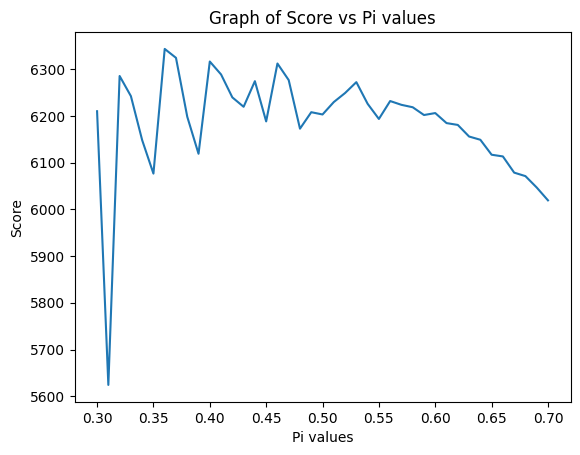

In [30]:
# Find intervals of pi
pivals = range(30,71)
pivals = np.array(pivals)/100
print(pivals)

M_t3 = 0
T_t3 = 10
N_t3 = 10000
alpha_t3 = 0.001

l_t3 = []
for pi in pivals :
    # find optimal shares sold and pathM
    S_t3, first_t3, momentum_t3,pathM_t3 = DP_memory(N_t3, T_t3, alpha_t3, pi,100)

    # Find paths
    pathn_t3 , spath_t3 = findpath(pathM_t3,momentum_t3,N_t3,S_t3,T_t3,100)

    # Append score
    l_t3.append(score(spath_t3))

# Find the best score and the best pi value
index_t3 = np.argmax(l_t3)
best_t3 = pivals[index_t3]

print(f"best pi value is : {best_t3}")

#Plotting
plt.plot(pivals, l_t3)
plt.xlabel("Pi values")
plt.ylabel("Score")
plt.title("Graph of Score vs Pi values")
plt.show()